<a href="https://colab.research.google.com/github/elenasofia98/PracticalNLP-2023-2024/blob/main/HoL01_1_AuthorshipAttribution_POSTagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification - Spooky Author Identification

Kaggle Hallowen challenge from 2017. Download from https://www.kaggle.com/competitions/spooky-author-identification/data

The goal is to predict the author from a dataset built from excerpts from horror stories by Edgar Allan Poe (EAP), Mary Shelley (MWS), and HP Lovecraft (HPL).

## Exploration & preprocessing

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, string

In [ ]:
df_train = pd.read_csv('SpookyAuthorIdentification_train.csv')
# df_test = pd.read_csv('data/SpookyAuthorIdentification/test.csv')

pd.set_option('display.max_colwidth', None)
df_train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.",EAP
1,id17569,It never once occurred to me that the fumbling might be a mere mistake.,HPL
2,id11008,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.",EAP
3,id27763,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.",MWS
4,id12958,"Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.",HPL


In [ ]:
import random
import math

random.seed(42)
index = df_train.index.tolist()
random.shuffle(index)

df_train = df_train.iloc[index].reset_index(drop=True)
index = df_train.index.tolist()
display(df_train.head())

,id,text,author
0,id10914,"It will have been, by that time, totally destroyed, at three different periods, by three successive earthquakes.",EAP
1,id03295,"Make me happy, and I shall again be virtuous.""",MWS
2,id04103,"The margin of the river, and of the many dazzling rivulets that glided through devious ways into its channel, as well as the spaces that extended from the margins away down into the depths of the streams until they reached the bed of pebbles at the bottom, these spots, not less than the whole surface of the valley, from the river to the mountains that girdled it in, were carpeted all by a soft green grass, thick, short, perfectly even, and vanilla perfumed, but so besprinkled throughout with the yellow buttercup, the white daisy, the purple violet, and the ruby red asphodel, that its exceeding beauty spoke to our hearts in loud tones, of the love and of the glory of God.",EAP
3,id26189,The heat became all at once intolerable.,EAP
4,id07955,"What, indeed, was my passion for the young girl of the valley in comparison with the fervor, and the delirium, and the spirit lifting ecstasy of adoration with which I poured out my whole soul in tears at the feet of the ethereal Ermengarde?",EAP


In [ ]:
i = math.ceil((len(index)/100)*80)
train_index = index[0:i]
test_index = index[i:]

df_test = df_train.iloc[test_index]
df_train = df_train.iloc[train_index]

len(df_train), len(df_test)

(15664, 3915)

In [ ]:
def find_missing(df):
    size = df.shape
    sum_duplicates = df.duplicated().sum()
    sum_null = df.isnull().sum().sum()
    is_NaN = df.isnull()
    row_has_NaN = is_NaN.any(axis=1)
    rows_with_NaN = df[row_has_NaN]
    count_NaN_rows = rows_with_NaN.shape
    return "Number of Samples: %d,\nNumber of Features: %d,\nDuplicated Entries: %d,\nNull Entries: %d,\nNumber of Rows with Null Entries: %d %.1f%%" %(size[0],size[1], sum_duplicates, sum_null,count_NaN_rows[0],(count_NaN_rows[0] / df.shape[0])*100)

def countplot(df, x, x_axis_title, y_axys_title, plot_title):
    plt.figure(figsize=(20,8))
    ax = sns.countplot(data=df, x=x, order=df[x].value_counts().index, palette="Blues_d")

    for p in ax.patches:
        ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(0, 3), rotation = 'horizontal',textcoords='offset points')

    plt.xticks(rotation=0)
    ax.set_xlabel(x_axis_title, weight='bold')

    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False)

    sns.despine(top=True, right=True, left=True, bottom=False)
    plt.title(plot_title, fontsize = 16,weight = 'bold')

Number of Samples: 15664,
Number of Features: 3,
Duplicated Entries: 0,
Null Entries: 0,
Number of Rows with Null Entries: 0 0.0%


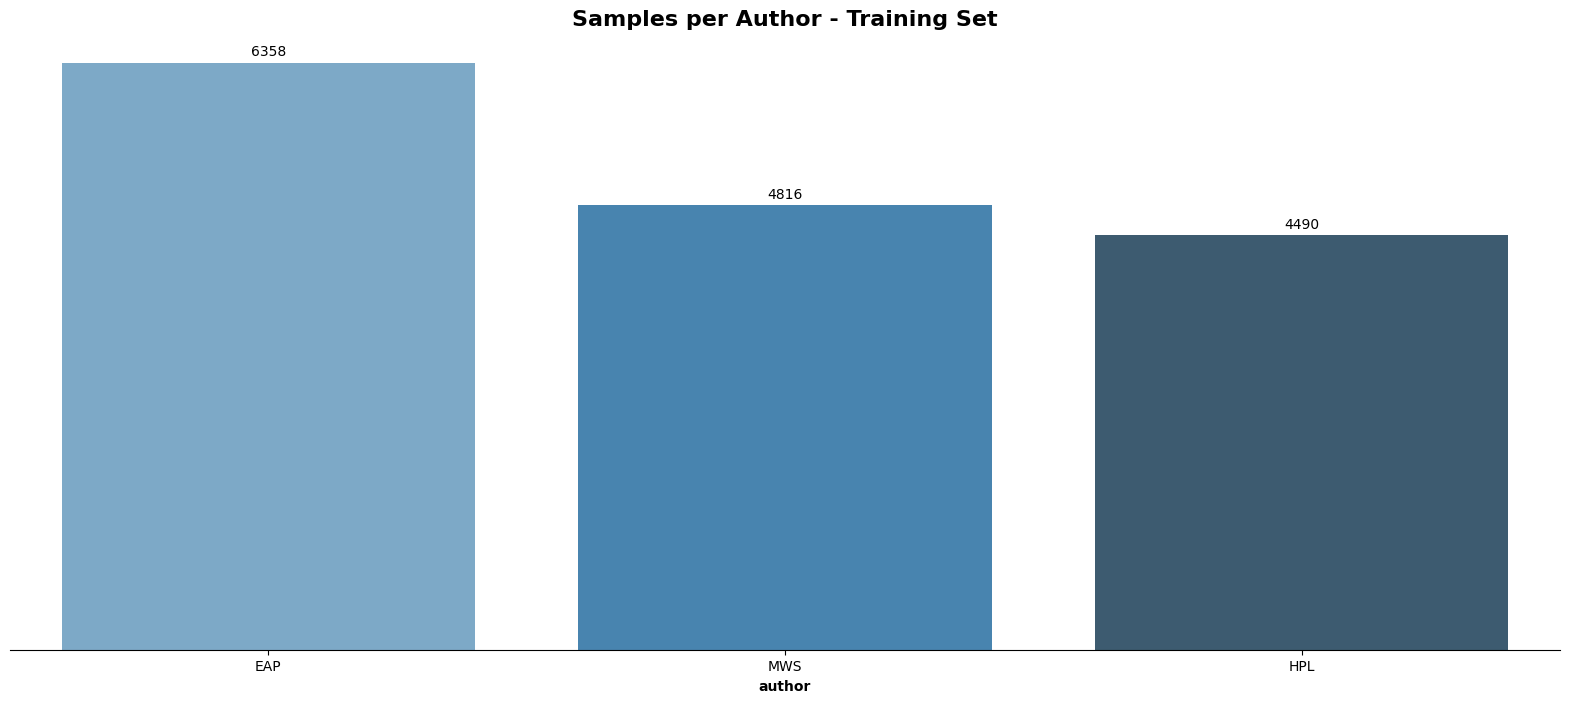

In [ ]:
print(find_missing(df_train))
countplot(df_train, x='author', x_axis_title='author', y_axys_title='Count', plot_title='Samples per Author - Training Set')

Number of Samples: 3915,
Number of Features: 3,
Duplicated Entries: 0,
Null Entries: 0,
Number of Rows with Null Entries: 0 0.0%


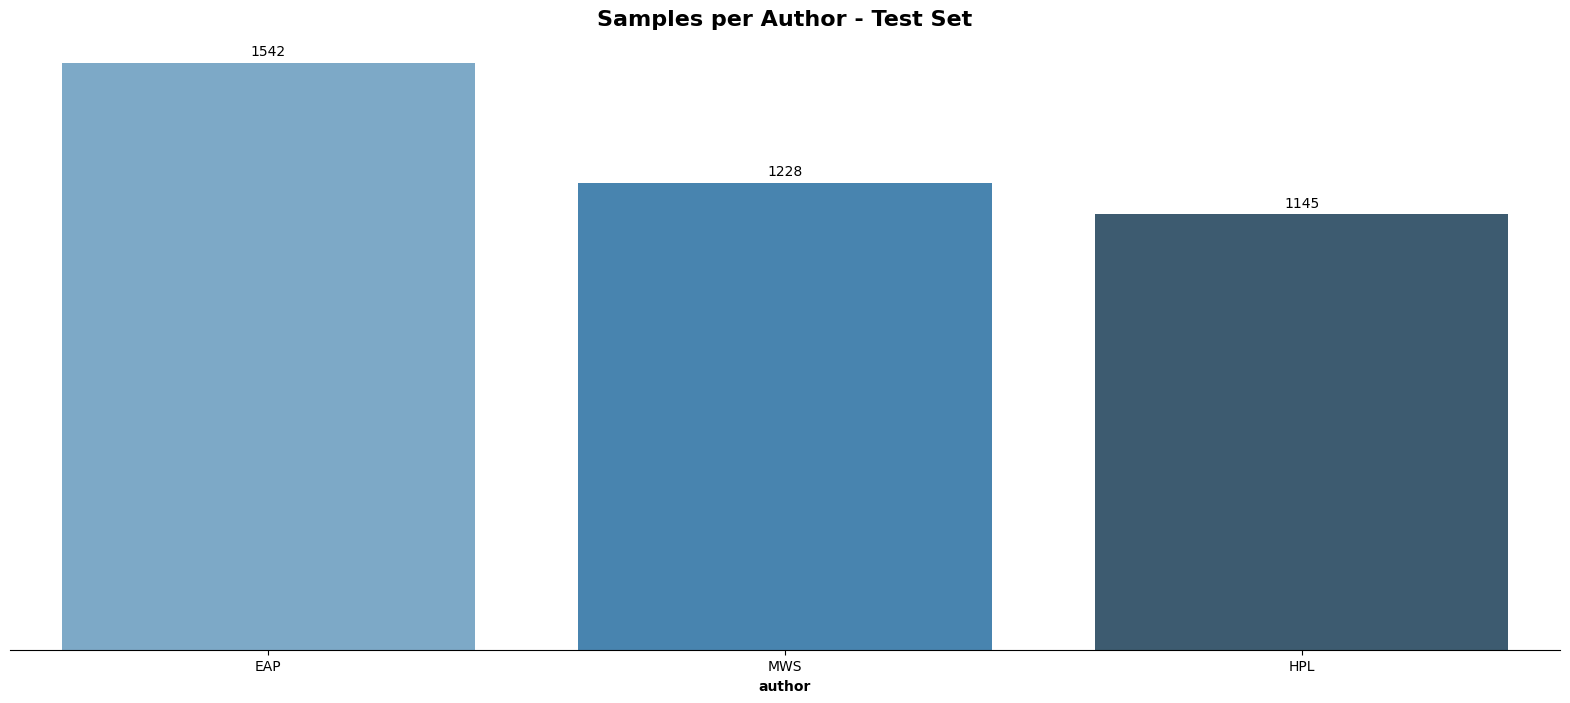

In [ ]:
print(find_missing(df_test))
countplot(df_test, x='author', x_axis_title='author', y_axys_title='Count', plot_title='Samples per Author - Test Set')

In [ ]:
# https://www.nltk.org/api/nltk.tokenize.html
from nltk.tokenize import word_tokenize
import re

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df_train['clean_text'] = df_train['text'].apply(lambda x: x.lower())
df_train['tokens'] = df_train['clean_text'].apply(word_tokenize)

In [ ]:
df_test['clean_text'] = df_test['text'].apply(lambda x: x.lower())
df_test['tokens'] = df_test['clean_text'].apply(word_tokenize)

In [ ]:
print("original train", len(df_train))

df_train['token_count'] = df_train['tokens'].apply(len)

for author in set(df_train['author'].values):
    print(author)
    stats = df_train[df_train['author']==author][['token_count']].describe()
    display(stats.loc[['mean', 'std', 'min', 'max']])

    max_len = stats.loc['mean']['token_count'] + stats.loc['std']['token_count']
    min_len = stats.loc['mean']['token_count'] - stats.loc['std']['token_count']

    df_train.drop(df_train[(df_train['author']==author)&(df_train['token_count']>max_len)].index, inplace = True)

print("after cleaning train", len(df_train))

original train 15664
HPL


,token_count
mean,30.865702
std,15.240012
min,5.000000
max,169.000000


MWS


,token_count
mean,31.189784
std,25.416344
min,4.000000
max,876.000000


EAP


,token_count
mean,29.385027
std,21.010292
min,4.000000
max,289.000000


after cleaning train 13801


# POS Tagging

#### Definitions
**POS tags** = Various parts of speech (POS) tags such as nouns, verbs, adjectives, and adverbs. POS tags are also known as word classes, morphological classes, or lexical tags.

**Pos Tagging** =
Associating each word in a sentence with a proper POS is known as POS tagging or POS annotation.

### Method
**Stochastic (Probabilistic) tagging**
The simplest stochastic approach finds out the most frequently used tag for a specific word in the annotated training data and uses this information to tag that word in the unannotated text.This approach comes up with sequences of tags for sentences that are not acceptable according to the grammar rules of a language!

Instead, an other possible approach is to calculate the probabilities of various tag sequences that are possible for a sentence. Then the probability of each sequence can be evaluated and the POS tags to assign are the sequence with the highest probability.

**Hidden Markov Models (HMMs)** are probabilistic approaches to assign a POS Tag.


https://www.nltk.org/api/nltk.tag.hmm.html

Hidden Markov Models (HMMs) largely used to assign the correct label sequence to sequential data.

These models are finite state machines characterised by:
- a number of states
- output symbols emitted while in each state
- transitions between these states

They can be represented as directed graphs:
- states are nodes: each state correspond to a POS tag
- each vertex emits an output symbol when entered (emission probability) defined over the output observation alphabet (symbols which may be observed as output of the system)
- probability weighted edges representing the probability of a transition between the source and sink states (generating a POS tag given the previous one)

HMMs hence share the Markov chain’s assumption, being that the probability of transition from one state to another only depends on the current state - i.e. the series of states that led to the current state are not used.

The aim is to identify the path (as a sequence of states) that maximize the probability of emitting the analyzed sequence.

Formally, a HMM can be characterised by:
- the transition probabilities $a_{ij} = P(s_t = j | s_{t-1} = i)$. These represent the probability of transition to each state from a given state.

- the output probability matrix $b_i(k) = P(X_t = o_k | s_t = i)$. These represent the probability of observing each symbol in a given state. We often refer to this output probabilities as "emission" probabilities.

- the initial state distribution. This gives the probability of starting in each state.

The Markov Chain assumption is used since the $P(s_t| s_1, ... s_{t-1})$ is assumed to be equivalent to $P(s_t| s_{t-1})$.
Ex: we are modeling the probability of generating a "Verb" knowing that a "Noun" has been generated, _not_ that a "Verb" is generated from a sequence such as "Article Name," for example.



## Train HMM Pos Tagger

https://www.mygreatlearning.com/blog/pos-tagging/


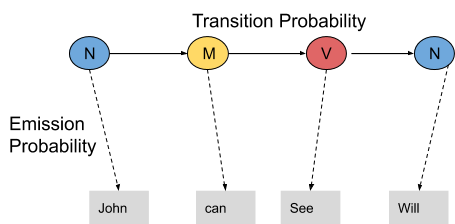

In [ ]:
# Import the toolkit and tags
import nltk
from nltk.corpus import brown


nltk.download('brown')
nltk.download('universal_tagset')

# Train data - pretagged
brown_data = brown.tagged_sents(tagset='universal')
print("len(brown_data)", len(brown_data))
print(brown_data[0])

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


len(brown_data) 57340
[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')]


Training of our HMM Tagger on the brown corpus. As a tagset, we will use the Universal Tagset (from the Universal Dependecy project)

In [ ]:
# Import HMM module - https://www.nltk.org/api/nltk.tag.hmm.html
from nltk.tag import hmm

# Setup a trainer with default(None) values
# And train with the data
trainer = hmm.HiddenMarkovModelTrainer()
tagger = trainer.train_supervised(brown_data)

# Prints the basic data about the tagger
print(tagger)

print(tagger.tag(df_train['tokens'].values[0]))
print(tagger.tag("Chicago is the birthplace of Ginny".split()))

<HiddenMarkovModelTagger 12 states and 56057 output symbols>
[('it', 'PRON'), ('will', 'VERB'), ('have', 'VERB'), ('been', 'VERB'), (',', '.'), ('by', 'ADP'), ('that', 'DET'), ('time', 'NOUN'), (',', '.'), ('totally', 'ADV'), ('destroyed', 'VERB'), (',', '.'), ('at', 'ADP'), ('three', 'NUM'), ('different', 'ADJ'), ('periods', 'NOUN'), (',', '.'), ('by', 'ADP'), ('three', 'NUM'), ('successive', 'ADJ'), ('earthquakes', 'NOUN'), ('.', '.')]
[('Chicago', 'NOUN'), ('is', 'VERB'), ('the', 'DET'), ('birthplace', 'NOUN'), ('of', 'ADP'), ('Ginny', 'DET')]


In [ ]:
print("states", tagger._states)
print("transition matrix", tagger._transitions_matrix().shape)
print("emission probabilities for tag == ADJ", tagger._outputs['ADJ'])

states ['DET', 'NOUN', 'ADJ', 'VERB', 'ADP', '.', 'ADV', 'CONJ', 'PRT', 'PRON', 'NUM', 'X']
transition matrix (12, 12)
emission probabilities for tag == ADJ <MLEProbDist based on 83721 samples>


In [ ]:
len([pos for s in brown_data for (x, pos) in s if pos == 'ADJ' ]) # check that the number of ADJ samples match the tagger indication

83721

In [ ]:
pos_tagger= tagger.tag #nltk.pos_tag

In [ ]:
df_train['pos'] = df_train['tokens'].apply(pos_tagger)
df_train["pos"]= df_train["pos"].apply(lambda x: [el[1] for el in x])


df_test['pos'] = df_test['tokens'].apply(pos_tagger)
df_test["pos"]= df_test["pos"].apply(lambda x: [el[1] for el in x])


df_train.head()

,id,text,author,clean_text,tokens,token_count,pos
0,id10914,"It will have been, by that time, totally destroyed, at three different periods, by three successive earthquakes.",EAP,"it will have been, by that time, totally destroyed, at three different periods, by three successive earthquakes.","[it, will, have, been, ,, by, that, time, ,, totally, destroyed, ,, at, three, different, periods, ,, by, three, successive, earthquakes, .]",22,"[PRON, VERB, VERB, VERB, ., ADP, DET, NOUN, ., ADV, VERB, ., ADP, NUM, ADJ, NOUN, ., ADP, NUM, ADJ, NOUN, .]"
1,id03295,"Make me happy, and I shall again be virtuous.""",MWS,"make me happy, and i shall again be virtuous.""","[make, me, happy, ,, and, i, shall, again, be, virtuous, ., '']",12,"[VERB, PRON, ADJ, ., CONJ, NOUN, VERB, ADV, VERB, ADJ, ., .]"
3,id26189,The heat became all at once intolerable.,EAP,the heat became all at once intolerable.,"[the, heat, became, all, at, once, intolerable, .]",8,"[DET, NOUN, VERB, PRT, ADP, ADV, ADJ, .]"
4,id07955,"What, indeed, was my passion for the young girl of the valley in comparison with the fervor, and the delirium, and the spirit lifting ecstasy of adoration with which I poured out my whole soul in tears at the feet of the ethereal Ermengarde?",EAP,"what, indeed, was my passion for the young girl of the valley in comparison with the fervor, and the delirium, and the spirit lifting ecstasy of adoration with which i poured out my whole soul in tears at the feet of the ethereal ermengarde?","[what, ,, indeed, ,, was, my, passion, for, the, young, girl, of, the, valley, in, comparison, with, the, fervor, ,, and, the, delirium, ,, and, the, spirit, lifting, ecstasy, of, adoration, with, which, i, poured, out, my, whole, soul, in, tears, at, the, feet, of, the, ethereal, ermengarde, ?]",49,"[DET, ., ADV, ., VERB, DET, NOUN, ADP, DET, ADJ, NOUN, ADP, DET, NOUN, ADP, NOUN, ADP, DET, NOUN, ., CONJ, DET, NOUN, ., CONJ, DET, NOUN, VERB, NOUN, ADP, DET, DET, DET, DET, DET, DET, DET, DET, DET, DET, DET, DET, DET, DET, DET, DET, DET, DET, DET]"
5,id19194,"For such follies, even in childhood, I had imbibed a taste and now they came back to me as if in the dotage of grief.",EAP,"for such follies, even in childhood, i had imbibed a taste and now they came back to me as if in the dotage of grief.","[for, such, follies, ,, even, in, childhood, ,, i, had, imbibed, a, taste, and, now, they, came, back, to, me, as, if, in, the, dotage, of, grief, .]",28,"[ADP, ADJ, NOUN, ., ADV, ADP, NOUN, ., NOUN, VERB, VERB, DET, NOUN, CONJ, ADV, PRON, VERB, ADV, ADP, PRON, ADV, ADP, ADP, DET, DET, DET, DET, DET]"


## Train of SVM Classifier on Bag Of POS representations

In [ ]:
def bag_of_pos(pos_tags_annotations, tagger):
    bop = []
    for pos_tags in pos_tags_annotations:
        count = {pos_tag: 0 for pos_tag in tagger._states}
        for pos_tag in pos_tags:
            count[pos_tag] +=1
        bop.append(count)
    return bop

In [ ]:
import numpy as np
from sklearn.feature_extraction import DictVectorizer


bop_train = bag_of_pos(df_train['pos'].values, tagger)

vectorizer = DictVectorizer()
vectorizer.fit(bop_train)

# summarize
print("Vocabulary: ", vectorizer.vocabulary_)

Vocabulary:  {'.': 0, 'ADJ': 1, 'ADP': 2, 'ADV': 3, 'CONJ': 4, 'DET': 5, 'NOUN': 6, 'NUM': 7, 'PRON': 8, 'PRT': 9, 'VERB': 10, 'X': 11}


In [ ]:
train_vector = vectorizer.transform(bag_of_pos(df_train['pos'].values, tagger))
test_vector =  vectorizer.transform(bag_of_pos(df_test['pos'].values, tagger))

https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.researchgate.net%2Ffigure%2Fsualizing-one-vs-all-multi-classification-of-SVM-for-three-classes-W-represent-binary_fig2_361930909&psig=AOvVaw02BXeVF2d1i0atq2GZduCX&ust=1699614863813000&source=images&cd=vfe&opi=89978449&ved=0CBMQjhxqFwoTCLjYs_PktoIDFQAAAAAdAAAAABAE

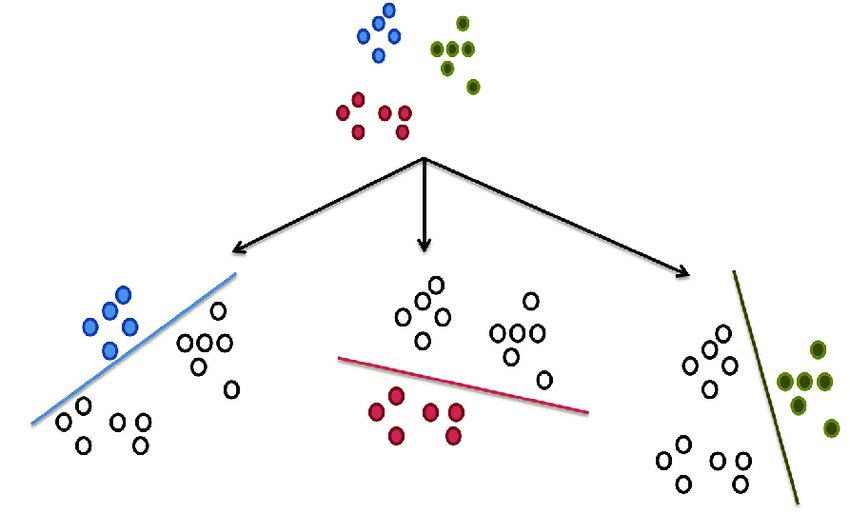

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', decision_function_shape='ovr')


train_labels = df_train['author']
SVM.fit(train_vector, train_labels)

SVC(kernel='linear')

In [ ]:
predictions_train_SVM = SVM.predict(train_vector)

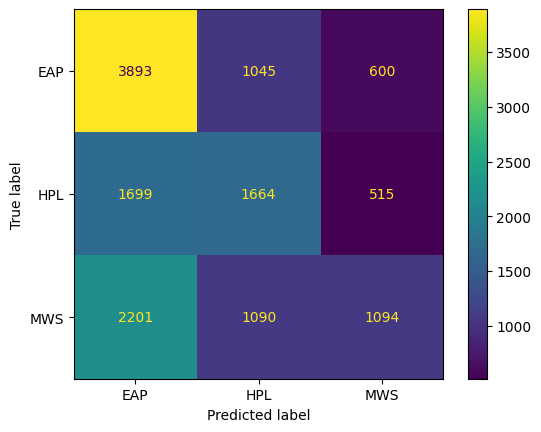

In [ ]:
cm = confusion_matrix(train_labels, predictions_train_SVM)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=SVM.classes_)

disp.plot()

In [ ]:
print(classification_report(y_pred=predictions_train_SVM, y_true=train_labels))

              precision    recall  f1-score   support

         EAP       0.50      0.70      0.58      5538
         HPL       0.44      0.43      0.43      3878
         MWS       0.50      0.25      0.33      4385

    accuracy                           0.48     13801
   macro avg       0.48      0.46      0.45     13801
weighted avg       0.48      0.48      0.46     13801



Evaluation on test data

In [ ]:
test_labels = df_test['author']

# predict the labels on test dataset
predictions_SVM = SVM.predict(test_vector)

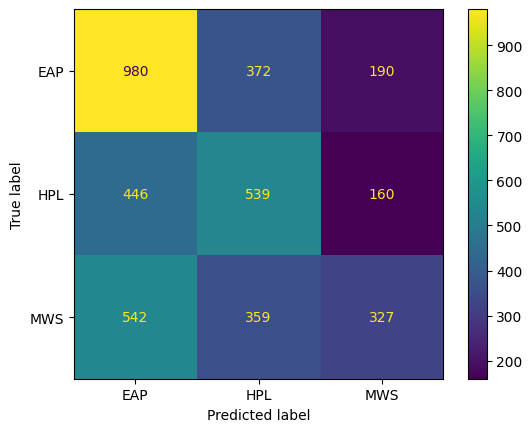

In [ ]:
cm = confusion_matrix(test_labels, predictions_SVM)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=SVM.classes_)

disp.plot()

In [ ]:
print(classification_report(y_pred=predictions_SVM, y_true=test_labels))

              precision    recall  f1-score   support

         EAP       0.50      0.64      0.56      1542
         HPL       0.42      0.47      0.45      1145
         MWS       0.48      0.27      0.34      1228

    accuracy                           0.47      3915
   macro avg       0.47      0.46      0.45      3915
weighted avg       0.47      0.47      0.46      3915



### Downsamplig

In [ ]:
from sklearn.utils import resample

downsample_EAP = resample(df_train[df_train['author']=='EAP'],
             replace=True,
             n_samples= int(len(df_train[df_train['author']!='EAP'])/2),
             random_state=42)

balanced_df_train = pd.concat([downsample_EAP, df_train[df_train['author']!='EAP']])
len(balanced_df_train)

12394

In [ ]:
bop_train = bag_of_pos(balanced_df_train['pos'].values, tagger)

vectorizer = DictVectorizer()
vectorizer.fit(bop_train)

# summarize
print("Vocabulary: ", vectorizer.vocabulary_)

Vocabulary:  {'.': 0, 'ADJ': 1, 'ADP': 2, 'ADV': 3, 'CONJ': 4, 'DET': 5, 'NOUN': 6, 'NUM': 7, 'PRON': 8, 'PRT': 9, 'VERB': 10, 'X': 11}


In [ ]:
train_vector = vectorizer.transform(bag_of_pos(balanced_df_train['pos'].values, tagger))
test_vector =  vectorizer.transform(bag_of_pos(df_test['pos'].values, tagger))

In [ ]:
SVM = svm.SVC(C=1.0, kernel='linear')


train_labels = balanced_df_train['author']
SVM.fit(train_vector, train_labels)

SVC(kernel='linear')

              precision    recall  f1-score   support

         EAP       0.48      0.55      0.51      4131
         HPL       0.46      0.55      0.50      3878
         MWS       0.51      0.35      0.42      4385

    accuracy                           0.48     12394
   macro avg       0.48      0.48      0.48     12394
weighted avg       0.48      0.48      0.47     12394



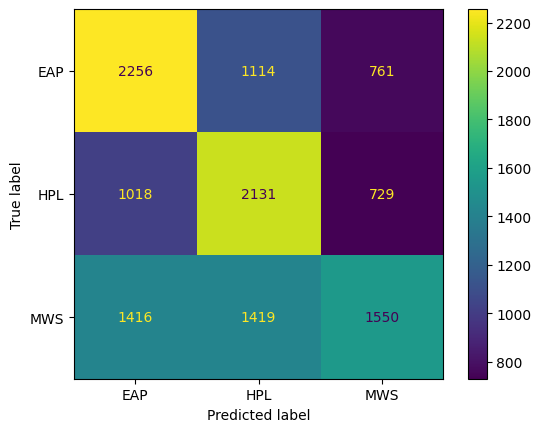

In [ ]:
predictions_train_SVM = SVM.predict(train_vector)

cm = confusion_matrix(train_labels, predictions_train_SVM)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=SVM.classes_)

disp.plot()
plt.plot()
print(classification_report(y_pred=predictions_train_SVM, y_true=train_labels))

              precision    recall  f1-score   support

         EAP       0.54      0.49      0.51      1542
         HPL       0.42      0.57      0.48      1145
         MWS       0.45      0.35      0.40      1228

    accuracy                           0.47      3915
   macro avg       0.47      0.47      0.46      3915
weighted avg       0.48      0.47      0.47      3915



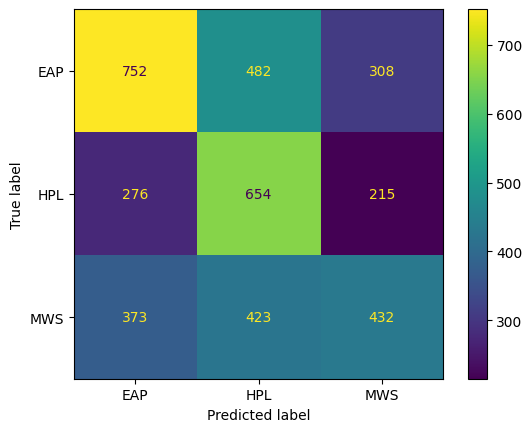

In [ ]:
test_labels = df_test['author']

# predict the labels on test dataset
predictions_SVM = SVM.predict(test_vector)


cm = confusion_matrix(test_labels, predictions_SVM)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=SVM.classes_)

disp.plot()
plt.plot()
print(classification_report(y_pred=predictions_SVM, y_true=test_labels))